In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generate dataset

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## PCA using SVD decomposition

In [3]:
X_centered  = X - X.mean(axis=0) # Data needs to be centered first before apply SVD decomposition

# Directly apply SVD
U, s, Vt = np.linalg.svd(X_centered)
## reduce to 2 dim from original 3 dim, by choose the 2 principle component (eigenvectors)
c1 = Vt.T[:, 0] 
c2 = Vt.T[:, 1]

In [4]:
print('The shape of unitary matrix U, singular values vector s and eigenvectors matrix Vt: {} {} {}'.format(U.shape,s.shape,Vt.shape))

The shape of unitary matrix U, singular values vector s and eigenvectors matrix Vt: (60, 60) (3,) (3, 3)


In [5]:
# build matrix S that matching the size of data matrix X and contains diagonal matrix with singular values
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s) # S.shape (60, 3)

In [6]:
# Compare the original X_centered with the reconstructed X, which should be similar
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [7]:
# another way of reconstructing the X

# select the first k columns of U where k = 3
U_short = U[:,:s.shape[0]] # 60x3

# since no feature reduction yet, the reconstructed X should be similar with orignal X_centered
np.allclose(X_centered, U_short.dot(np.diag(s)).dot(Vt)) # 60x3(m,k) 3x3(k,k) 3x3(k,k)

True

In [8]:
# Projecting the training set down to 2 dimensions
# Construct a projection matrix W from the “top” k eigenvectors, where k = 2
W2 = Vt.T[:, :2] # select the first 2 eigenvectors (principal components)
X2D = X_centered.dot(W2)

In [9]:
X2D_using_svd = X2D

In [10]:
# Print out for later comparision with PCA using Scikit-Learn
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

## PCA using Scikit-Learn

In [11]:
from sklearn.decomposition import PCA

# No need for the center the points
pca = PCA(n_components = 2) # When n_compoents > 1, it represent the number of priciple component
X2D = pca.fit_transform(X)

In [12]:
X2D[:5] # same result as above by using SVD decomposition

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In general the only difference by running PCA is that some axes may be flipped. <br>
In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped.

In [13]:
np.allclose(X2D, -X2D_using_svd)

True

In [14]:
# input the compressed dataset to reconstruct the original dataset
X3D_inv = pca.inverse_transform(X2D)

In [15]:
np.allclose(X3D_inv, X) # lost some information after compression and decompression of the dataset

False

There was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points.

## PCA Attributes

In [16]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

components_: ndarray of shape (n_components, n_features) <br>
Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.

In [17]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [18]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

explained_variance_: ndarray of shape (n_components,) <br>
The amount of variance explained by each of the selected components. Equal to n_components largest eigenvalues of the covariance matrix of X.

84.25% of the variance being preserved by the 1st principal axis, while 14.63% being preserved by the 2nd

In [19]:
# reconstruction error
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

In [20]:
pca.mean_.shape

(3,)

mean_: ndarray of shape (n_features,) <br>
Per-feature empirical mean, estimated from the training set. Equal to X.mean(axis=0).

## MNIST

In [21]:
from six.moves import urllib
# from tensorflow.examples.tutorials.mnist import input_data

# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
# mnist = fetch_mldata('MNIST original', transpose_data=True, data_home='files')

In [22]:
from sklearn.datasets import fetch_openml

from scipy.io import loadmat
mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}
print("Success!")

Success!


In [23]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 # np.argmax() Returns the indices of the maximum values along an axis.

In [25]:
d

154

In [26]:
# Another way result the same result above
pca = PCA(n_components=0.95) # When n_compoents < 1, it represent the target explained variance ratio
X_reduced = pca.fit_transform(X_train)

In [27]:
pca.n_components_

154

In [28]:
np.sum(pca.explained_variance_ratio_)

0.9504463030200188

In [29]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [30]:
X_reduced_pca = X_reduced # used to compare later with incremental PCA reduced dataset

## Incremental PCA

Preceding implementation of PCA requires the whole training set to fit in memory in order for the SVD algorithm to run. <br> Incremental PCA: Split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time.

In [31]:
# When the dataset is too large, use incremental PCA, which means split dataset into batches and pass it to the PCA
from sklearn.decomposition import IncrementalPCA

n_batches = 100

inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [32]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

In [33]:
X_reduced_inc_pca = X_reduced

In [34]:
np.allclose(pca.mean_, inc_pca.mean_) # pca.mean_: Equal to X.mean(axis=0).

True

In [35]:
np.allclose(X_reduced_pca, X_reduced_inc_pca) # expect incremental PCA lose more information then normal PCA

False

## Kernel PCA

Kernel trick, a mathematical technique that implicitly maps instances into a very high-demensional space, enabling nonlinear calssification and regression with Support Vector Machines. (nonlinear in original space -> linear in high-dimensional feature space) 

In [36]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=0)
y = t > 6.9 # simple binary classification

In [37]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04) # gamma control how thick the point, the height of the bell shape
X_reduced = rbf_pca.fit_transform(X) # reduced to 2 dimentional dataset

Selecting a Kernel and Tuning Hyperparameters

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [39]:
print(grid_search.best_params_)

{'kpca__gamma': 0.04111111111111111, 'kpca__kernel': 'rbf'}


In [40]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0411,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced) # X_preimage is the reconstructed dataset

In [41]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

29.95637488124628

## LLE

In [42]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=0)

In [43]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=0)
X_reduced = lle.fit_transform(X)

<IPython.core.display.Javascript object>


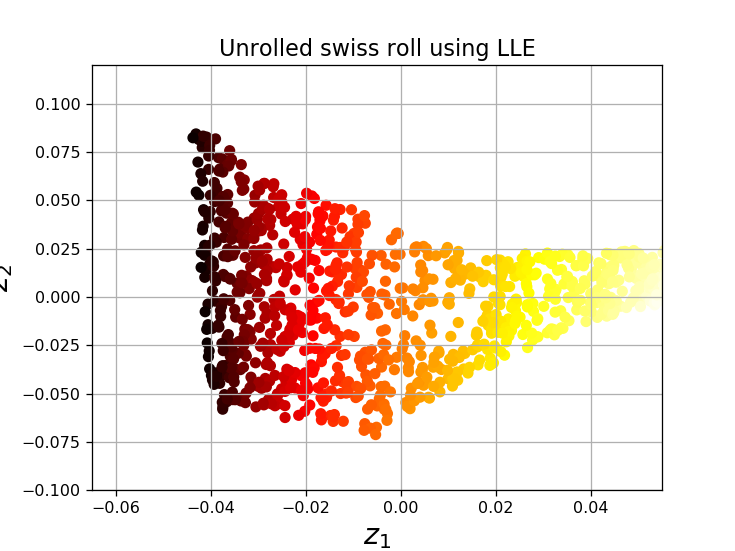

In [44]:
%matplotlib notebook 

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)